# Подготовка данных

Далее создается иерархия классов, проводится базовый анализ датасета

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("data/train_40k.csv").dropna(how='any')

# Define a list with sentences (1k - 100k sentences)
train_sentences = df['Text'].tolist()
labels = df[['Cat1', 'Cat2', 'Cat3']].to_numpy()
labels

array([['grocery gourmet food', 'meat poultry', 'jerky'],
       ['toys games', 'games', 'unknown'],
       ['toys games', 'games', 'unknown'],
       ...,
       ['beauty', 'tools accessories', 'mirrors'],
       ['beauty', 'skin care', 'body'],
       ['beauty', 'fragrance', 'women s']], dtype=object)

<Axes: xlabel='Cat3'>

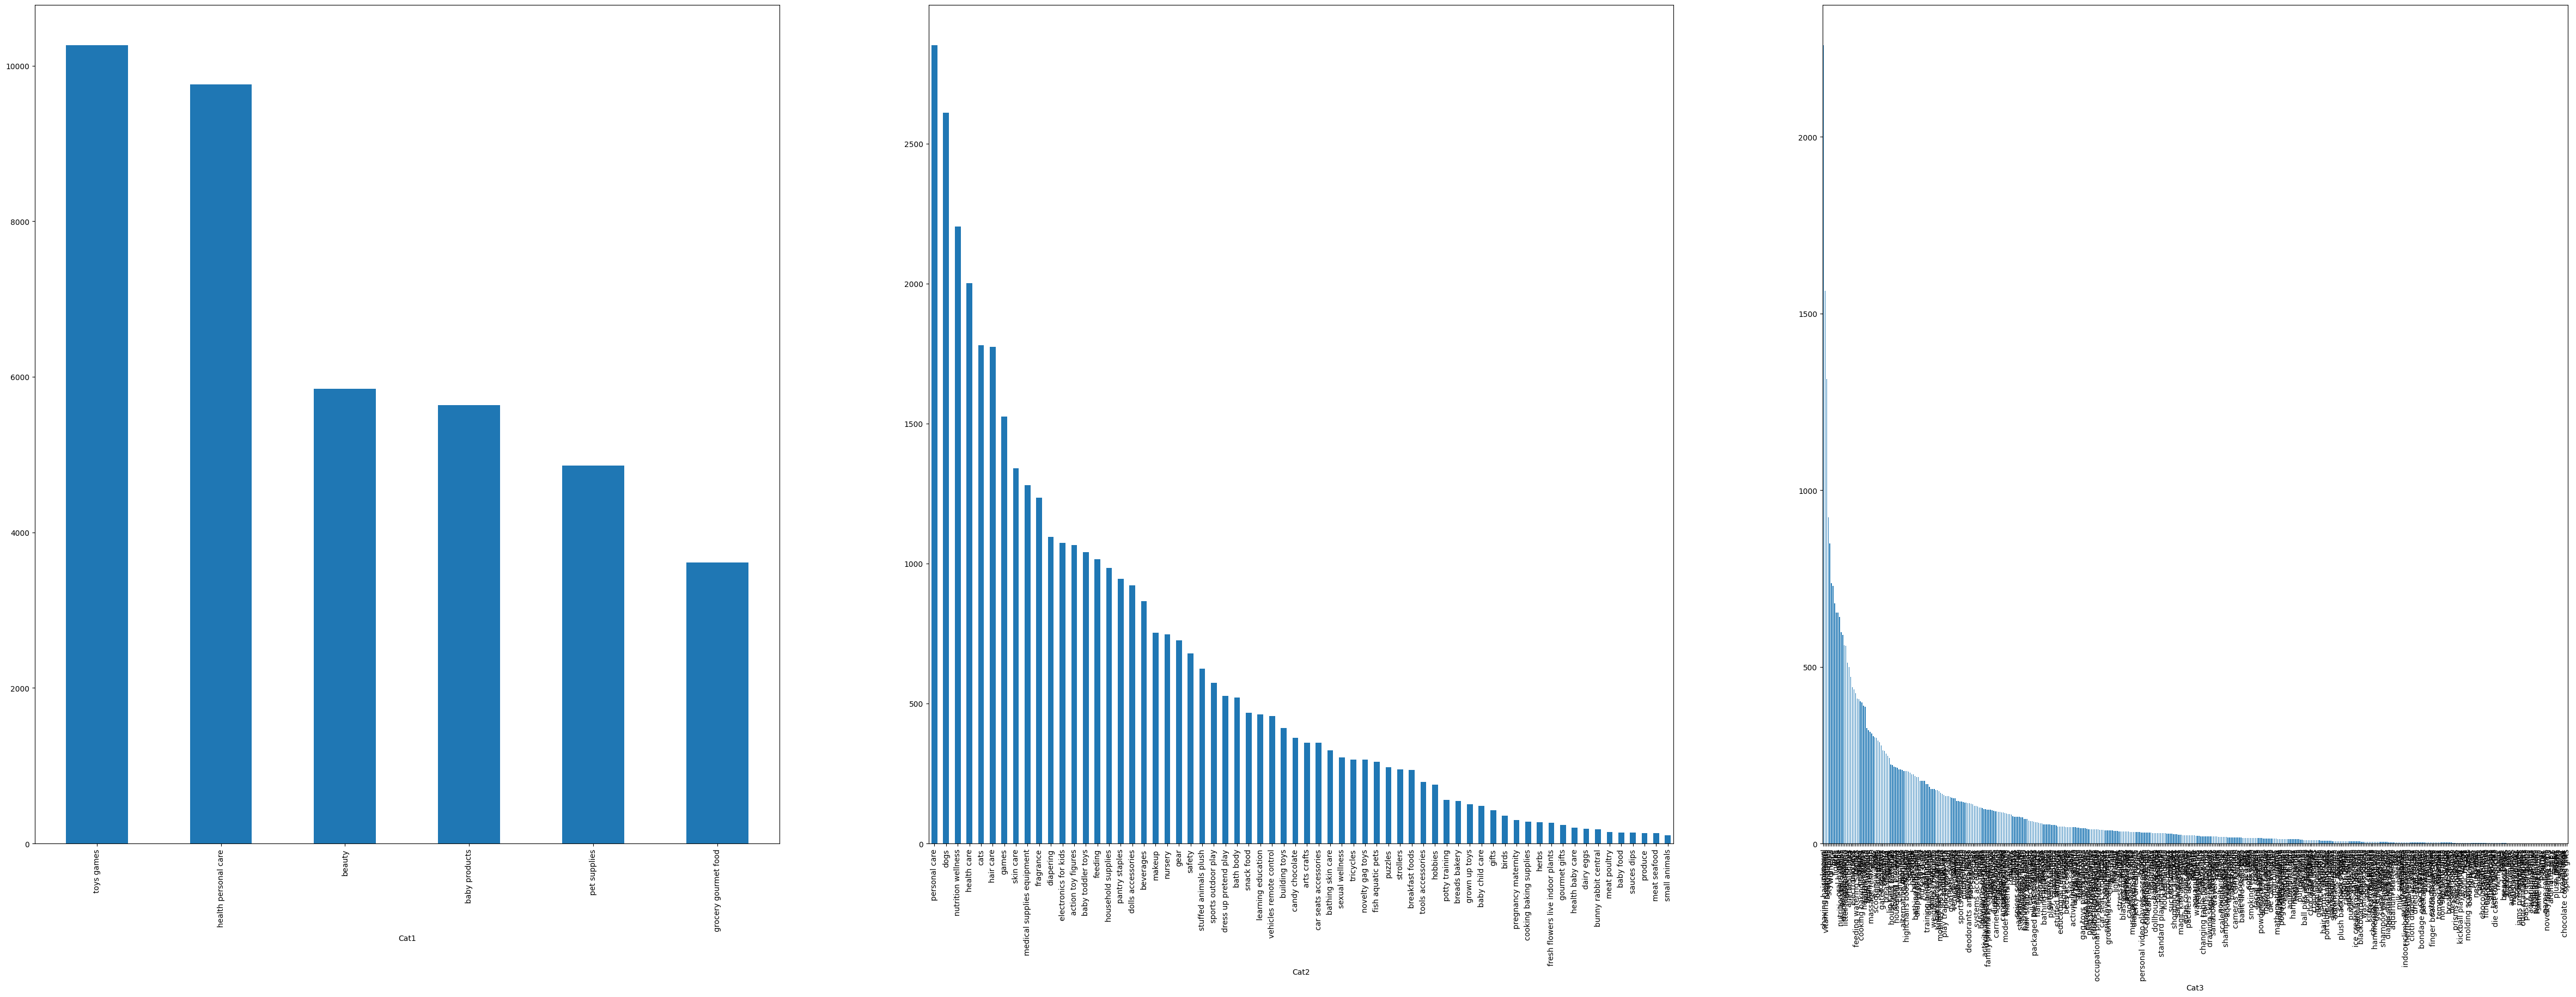

In [42]:
fig, ax = plt.subplots(ncols=3, figsize=(60, 20))
df['Cat1'].value_counts().plot(ax=ax[0], kind='bar')
df['Cat2'].value_counts().plot(ax=ax[1], kind='bar')
df['Cat3'].value_counts().plot(ax=ax[2], kind='bar')

In [43]:
from ydata_profiling import ProfileReport

ProfileReport(df[['Text', 'Cat1', 'Cat2', 'Cat3']], title="Profiling Report").to_file("ydata_report.html")

/home/ramil/miniconda3/envs/ml/lib/python3.11/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

~~Балансировка классов предлагает молиться~~. Согласно отчёту, в датасете 0.7% дубликатов, все одного класса

### Создание иерархии

In [44]:
def create_hierarchy(df):
    hierarchy = {}

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        current_level = hierarchy  # Start from the root of the hierarchy

        # Build the path based on the values in the current row
        for col in df.columns:
            label = row[col]
            if pd.notna(label):  # Check if the label is not NaN
                # If the label doesn't exist in the current level, add it
                if label not in current_level:
                    current_level[label] = {}
                # Move down to the next level in the hierarchy
                current_level = current_level[label]

    return hierarchy

hierarchy = {'root': create_hierarchy(df[['Cat1', 'Cat2', 'Cat3']])}

In [45]:
hierarchy

{'root': {'grocery gourmet food': {'meat poultry': {'jerky': {},
    'p t s': {},
    'seafood': {},
    'exotic meats': {},
    'sausages': {},
    'unknown': {},
    'pork': {}},
   'beverages': {'juices': {},
    'tea': {},
    'coffee': {},
    'soft drinks': {},
    'powdered drink mixes': {},
    'unknown': {},
    'energy drinks': {},
    'hot cocoa': {},
    'coconut water': {},
    'water': {},
    'cocktail mixers': {},
    'sports drinks': {}},
   'gourmet gifts': {'snack gifts': {},
    'dessert gifts': {},
    'tea gifts': {},
    'cheese gifts': {},
    'candy gifts': {},
    'sauces gifts': {},
    'seafood gifts': {},
    'coffee gifts': {},
    'chocolate gifts': {},
    'unknown': {},
    'fruit gifts': {},
    'jams preserves gifts': {},
    'meat gifts': {},
    'spices gifts': {}},
   'sauces dips': {'sauces': {}, 'dips': {}},
   'breakfast foods': {'cereals': {},
    'breakfast cereal bars': {},
    'toaster pastries': {}},
   'pantry staples': {'unknown': {},
   

# Обучение TF-IDF и иерархического классификатора
Помимо TF-IDF на unlabeled текстах был дообучен DistilRoberta, но точность на эмбеддингах Bert и на TF-IDF не отличается

In [46]:
pretrain_texts = pd.read_csv("data/unlabeled_150k.csv").dropna(how='any')['Text'].tolist()
tfidf_text = pretrain_texts + train_sentences

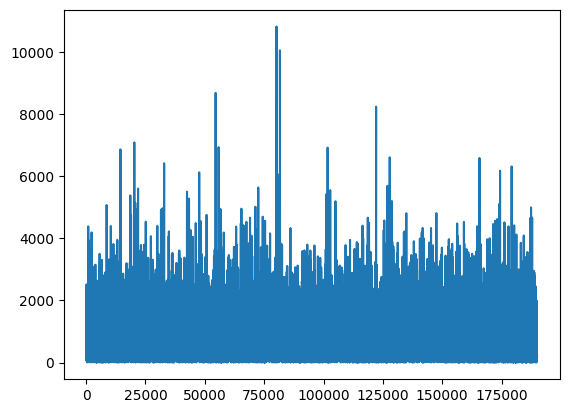

In [47]:
plt.plot(pd.Series(tfidf_text).str.len().tolist())

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(tfidf_text)
embeddings = tfidf_vectorizer.transform(train_sentences)

In [49]:
from model_serving.app.services.lib import TopDownClassifier
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier
top_down_clf = TopDownClassifier(base_classifier, hierarchy)
top_down_clf.fit(embeddings, labels)

TopDownClassifier(base_classifier=<class 'sklearn.tree._classes.DecisionTreeClassifier'>,
                  config={},
                  hierarchy={'root': {'baby products': {'bathing skin care': {'aromatherapy': {},
                                                                              'bathing tubs seats': {},
                                                                              'bubble bath': {},
                                                                              'gift sets': {},
                                                                              'grooming healthcare kits': {},
                                                                              'non slip bath mats': {},
                                                                              'skin care': {},
                                                                              'soaps cleansers': {},
                                                                              'unknown': {},
                                                                              'washcloths towels': {}},
                                                        'car seats...
                                                                             'slumber bags': {},
                                                                             'sports': {},
                                                                             'unknown': {},
                                                                             'yo yos': {}},
                                                     'stuffed animals plush': {'animals figures': {},
                                                                               'plush backpacks purses': {},
                                                                               'plush pillows': {},
                                                                               'plush puppets': {},
                                                                               'puppets': {},
                                                                               'teddy bears': {},
                                                                               'unknown': {}},
                                                     'tricycles': {'scooters wagons': {}},
                                                     'vehicles remote control': {'die cast vehicles': {},
                                                                                 'play trains railway sets': {},
                                                                                 'play vehicles': {},
                                                                                 'unknown': {},
                                                                                 'vehicle playsets': {}}}}})

In [50]:
df = pd.read_csv("data/val_10k.csv").dropna(how='any')

test_sentences = df['Text'].tolist()
test_labels = df[['Cat1', 'Cat2', 'Cat3']].to_numpy()

In [51]:
test_embeddings = tfidf_vectorizer.transform(test_sentences)

In [52]:
y_pred = top_down_clf.predict(test_embeddings)

In [53]:
y_pred

array([['pet supplies', 'dogs', 'doors'],
       ['health personal care', 'medical supplies equipment', 'braces'],
       ['pet supplies', 'dogs', 'collars'],
       ...,
       ['baby products', 'bathing skin care', 'grooming healthcare kits'],
       ['toys games', 'electronics for kids', 'electronic toys'],
       ['health personal care', 'health care', 'pain relievers']],
      dtype='<U34')

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Предполагается, что y_true и y_pred имеют форму (n_samples, n_outputs)
n_outputs = test_labels.shape[1]

# Инициализация переменных для накопления метрик
accuracies = []
precisions = []
recalls = []
f1s = []

for i in range(n_outputs):
    # Вычисление метрик для каждого уровня иерархии отдельно
    accuracy = accuracy_score(test_labels[:, i], y_pred[:, i])
    precision = precision_score(test_labels[:, i], y_pred[:, i], average='macro')
    recall = recall_score(test_labels[:, i], y_pred[:, i], average='macro')
    f1 = f1_score(test_labels[:, i], y_pred[:, i], average='macro')
    
    # Добавление метрик в списки
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Усреднение метрик по всем уровням иерархии
average_accuracy = sum(accuracies) / n_outputs
average_precision = sum(precisions) / n_outputs
average_recall = sum(recalls) / n_outputs
average_f1 = sum(f1s) / n_outputs

# Вывод результатов
print(f'Average Accuracy: {average_accuracy:.4f}')
print(f'Average Precision (Macro): {average_precision:.4f}')
print(f'Average Recall (Macro): {average_recall:.4f}')
print(f'Average F1 Score (Macro): {average_f1:.4f}')

print(f'Accuracies: {accuracies}')
print(f'precisions: {precisions}')
print(f'Recalls: {recalls}')
print(f'F1s: {f1s}')

Average Accuracy: 0.3904
Average Precision (Macro): 0.2945
Average Recall (Macro): 0.2928
Average F1 Score (Macro): 0.2886
Accuracies: [0.5890945472736369, 0.3469734867433717, 0.23501750875437719]
precisions: [0.5708604173339145, 0.21607440121341764, 0.09669820854073528]
Recalls: [0.5767008302828738, 0.20985819150163243, 0.09180104295480532]
F1s: [0.5714173687188108, 0.2072999751861676, 0.08720149316590645]


/home/ramil/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ramil/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Обучение плоского классификатора
**В силу того, что плоская логрегрессия обучалась два часа, съела 20 Гб RAM и не показала никакого результата, дальше обучен DecisionTreeClassifier (точность логрегрессии приведена ниже)**

In [31]:
import pandas as pd

df = pd.read_csv("data/train_40k.csv").dropna(how='any')
train_sentences = df['Text'].tolist()
train_labels = df[['Cat1', 'Cat2', 'Cat3']].to_numpy()
train_labels = train_labels[:,0] + "_" + train_labels[:,1] + "_" + train_labels[:,2]

In [32]:
train_labels

array(['grocery gourmet food_meat poultry_jerky',
       'toys games_games_unknown', 'toys games_games_unknown', ...,
       'beauty_tools accessories_mirrors', 'beauty_skin care_body',
       'beauty_fragrance_women s'], dtype=object)

In [55]:
df = pd.read_csv("data/val_10k.csv").dropna(how='any')
test_sentences = df['Text'].tolist()
test_labels = df[['Cat1', 'Cat2', 'Cat3']].to_numpy()
test_labels = test_labels[:,0] + "_" + test_labels[:,1] + "_" + test_labels[:,2]

In [56]:
test_labels

array(['pet supplies_cats_cat flaps',
       'pet supplies_bunny rabbit central_food',
       'health personal care_health care_massage relaxation', ...,
       'pet supplies_dogs_carriers travel products',
       'pet supplies_dogs_toys',
       'health personal care_medical supplies equipment_occupational physical therapy aids'],
      dtype=object)

In [57]:
from sklearn.tree import DecisionTreeClassifier

train_embeddings = tfidf_vectorizer.transform(train_sentences)
regressor = DecisionTreeClassifier(random_state=42)
regressor.fit(train_embeddings, train_labels)

DecisionTreeClassifier(random_state=42)

In [58]:
test_embeddings = tfidf_vectorizer.transform(test_sentences)
y_pred = regressor.predict(test_embeddings)

In [59]:
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average='macro')
recall = recall_score(test_labels, y_pred, average='macro')
f1 = f1_score(test_labels, y_pred, average='macro')

/home/ramil/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ramil/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (Macro): {precision:.4f}')
print(f'Recall (Macro): {recall:.4f}')
print(f'F1 Score (Macro): {f1:.4f}')

Accuracy: 0.2659
Precision (Macro): 0.1044
Recall (Macro): 0.1003
F1 Score (Macro): 0.0944


### Результаты иерархической классификации с DecisionTreeClassifier
```
Average Accuracy: 0.3904
Average Precision (Macro): 0.2945
Average Recall (Macro): 0.2928
Average F1 Score (Macro): 0.2886
Accuracies: [0.5890945472736369, 0.3469734867433717, 0.23501750875437719]
Precisions: [0.5708604173339145, 0.21607440121341764, 0.09669820854073528]
Recalls: [0.5767008302828738, 0.20985819150163243, 0.09180104295480532]
F1s: [0.5714173687188108, 0.2072999751861676, 0.08720149316590645]```
```
### Результаты иерархической классификации с LogisticRegression
```
Average Accuracy: 0.5967
Average Precision (Macro): 0.4970
Average Recall (Macro): 0.4198
Average F1 Score (Macro): 0.4296```

Иерархическая классификация успешно повышает точность классификации

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [64]:
df = pd.read_csv("data/val_10k.csv").dropna(how='any')
y_pred = top_down_clf.predict(test_embeddings)

### Первая колонка
По confusion matrix заметно, что уже на первом уровне модель совершает много ошибок

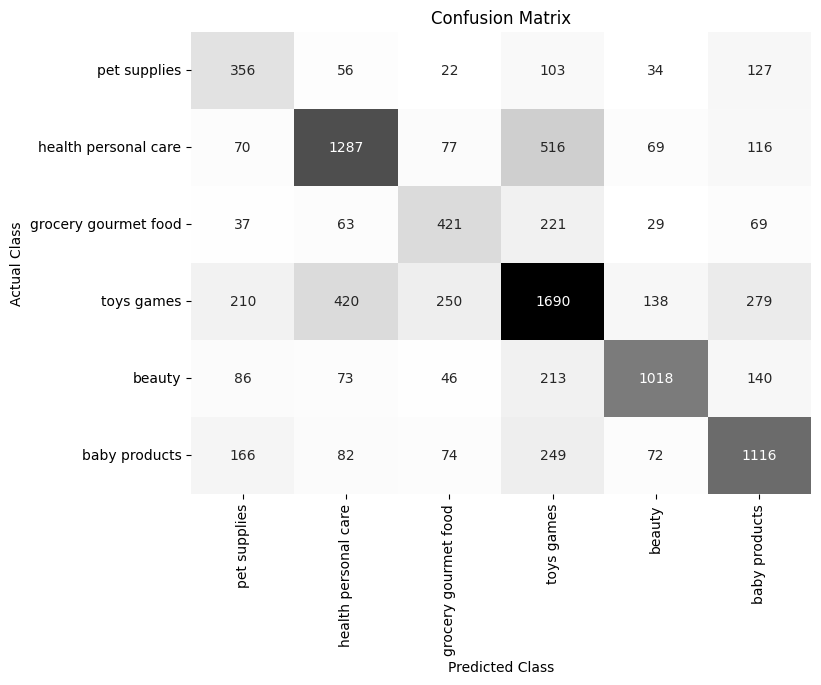

In [93]:
conf_matrix = confusion_matrix(df['Cat1'], y_pred[:,0])
# Создаем heatmap для визуализации матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', cbar=False, xticklabels=df['Cat1'].unique(), yticklabels=df['Cat1'].unique())
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

In [80]:
classification_report(df['Cat1'], y_pred[:,0])

'                      precision    recall  f1-score   support\n\n       baby products       0.38      0.51      0.44       698\n              beauty       0.65      0.60      0.63      2135\ngrocery gourmet food       0.47      0.50      0.49       840\nhealth personal care       0.56      0.57      0.57      2987\n        pet supplies       0.75      0.65      0.69      1576\n          toys games       0.60      0.63      0.62      1759\n\n            accuracy                           0.59      9995\n           macro avg       0.57      0.58      0.57      9995\n        weighted avg       0.60      0.59      0.59      9995\n'

In [99]:
accuracies = {}
for i, class_name in enumerate(df['Cat1'].unique()):
    # Точность класса определяется как количество правильно предсказанных экземпляров
    # деленное на общее количество экземпляров данного класса
    class_accuracy = conf_matrix[i, i] / conf_matrix[i].sum()
    accuracies[class_name] = class_accuracy

# Сортируем классы по точности в порядке убывания
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

In [100]:
sorted_accuracies

[('beauty', 0.6459390862944162),
 ('baby products', 0.6344513928368392),
 ('health personal care', 0.6028103044496487),
 ('toys games', 0.5657850686307332),
 ('pet supplies', 0.5100286532951289),
 ('grocery gourmet food', 0.5011904761904762)]

Также можно заметить, что класс с наименьшим количеством примеров в датасете классифицируется хуже всего, что заметно и далее

### Вторая колонка

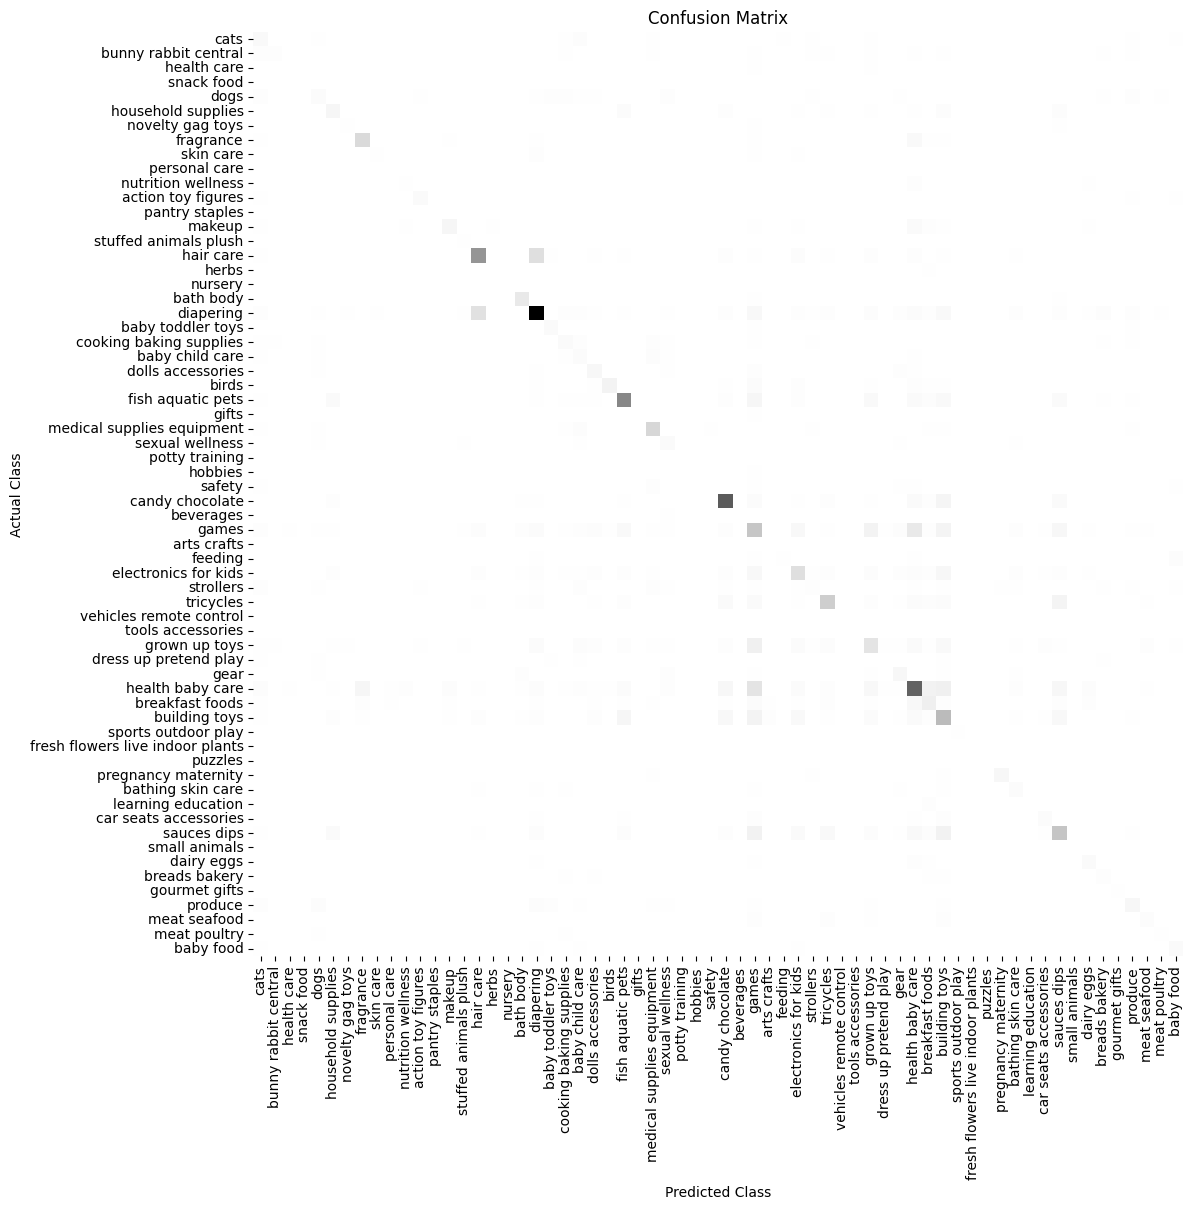

In [102]:
conf_matrix = confusion_matrix(df['Cat2'], y_pred[:,1])
# Создаем heatmap для визуализации матрицы ошибок
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Greys', cbar=False, xticklabels=df['Cat2'].unique(), yticklabels=df['Cat2'].unique())
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

In [103]:
classification_report(df['Cat2'], y_pred[:,1])

'                                  precision    recall  f1-score   support\n\n              action toy figures       0.12      0.22      0.16       115\n                     arts crafts       0.16      0.11      0.13        99\n                 baby child care       0.00      0.00      0.00        37\n                       baby food       0.00      0.00      0.00         2\n               baby toddler toys       0.13      0.13      0.13       139\n                       bath body       0.24      0.27      0.25       142\n               bathing skin care       0.11      0.09      0.10        46\n                       beverages       0.57      0.55      0.56       215\n                           birds       0.30      0.12      0.17        51\n                   breads bakery       0.12      0.14      0.12        22\n                 breakfast foods       0.16      0.15      0.16        39\n                   building toys       0.28      0.25      0.26        89\n            bunny rabb

In [104]:
accuracies = {}
for i, class_name in enumerate(df['Cat2'].unique()):
    # Точность класса определяется как количество правильно предсказанных экземпляров
    # деленное на общее количество экземпляров данного класса
    class_accuracy = conf_matrix[i, i] / conf_matrix[i].sum()
    accuracies[class_name] = class_accuracy

# Сортируем классы по точности в порядке убывания
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

In [105]:
sorted_accuracies[:10]

[('candy chocolate', 0.6365313653136532),
 ('bath body', 0.5735294117647058),
 ('medical supplies equipment', 0.5630630630630631),
 ('fragrance', 0.5534883720930233),
 ('diapering', 0.5497142857142857),
 ('fish aquatic pets', 0.5155642023346303),
 ('hair care', 0.5084033613445378),
 ('tricycles', 0.3803191489361702),
 ('pregnancy maternity', 0.36666666666666664),
 ('health baby care', 0.3661504424778761)]

In [106]:
sorted_accuracies[-10:]

[('snack food', 0.0),
 ('gifts', 0.0),
 ('potty training', 0.0),
 ('safety', 0.0),
 ('beverages', 0.0),
 ('arts crafts', 0.0),
 ('vehicles remote control', 0.0),
 ('tools accessories', 0.0),
 ('puzzles', 0.0),
 ('small animals', 0.0)]

На втором уровне классы, которых в датасете было мало, не были верно предсказаны вовсе

### Третья колонка
На третьем уровне существуют значения, которые моделью не были предсказаны вовсе (в датасете присутствуют классы, встречающиеся лишь единожды)

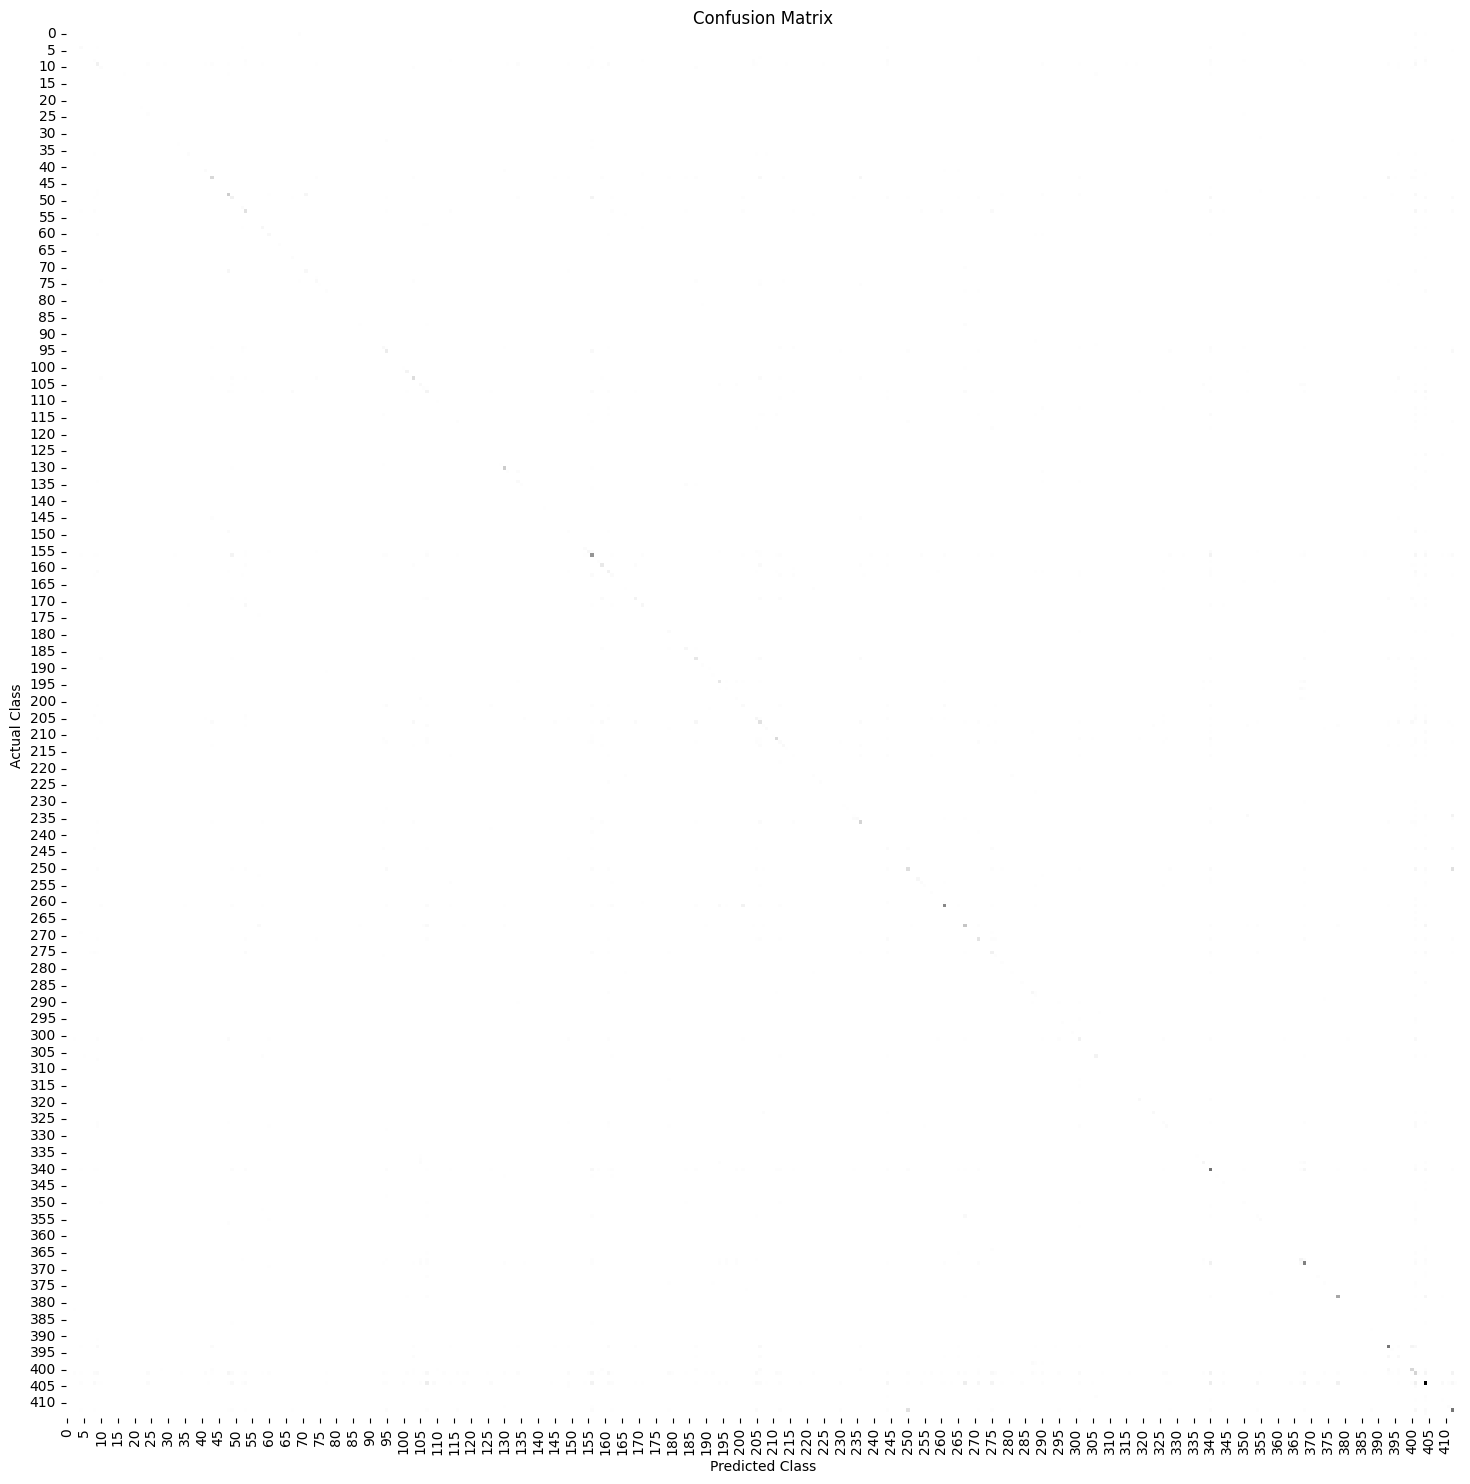

In [107]:
conf_matrix = confusion_matrix(df['Cat3'], y_pred[:,2])
# Создаем heatmap для визуализации матрицы ошибок
plt.figure(figsize=(18, 18))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Greys', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

In [108]:
classification_report(df['Cat3'], y_pred[:,2])

/home/ramil/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ramil/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ramil/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ramil/

'                                    precision    recall  f1-score   support\n\n                       accessories       0.09      0.11      0.10        37\n                action toy figures       0.00      0.00      0.00         3\n     activity centers entertainers       0.05      0.09      0.06        11\n             activity play centers       0.00      0.00      0.00         2\n                  adult toys games       0.13      0.12      0.13        49\n                    air fresheners       0.00      0.00      0.00         8\n                            albums       0.00      0.00      0.00         2\n                           allergy       0.06      0.04      0.05        26\n              alternative medicine       0.05      0.05      0.05        74\n                   animals figures       0.16      0.16      0.16       139\n               apparel accessories       0.14      0.16      0.15        32\n                     aprons smocks       0.00      0.00      0.00        

In [112]:
import math

accuracies = {}
for i, class_name in enumerate(df['Cat2'].unique()):
    # Точность класса определяется как количество правильно предсказанных экземпляров
    # деленное на общее количество экземпляров данного класса
    class_accuracy = conf_matrix[i, i] / conf_matrix[i].sum()
    accuracies[class_name] = class_accuracy

# Сортируем классы по точности в порядке убывания
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1] if not math.isnan(x[1]) else .0, reverse=True)

/tmp/ipykernel_214/697147794.py:7: RuntimeWarning: invalid value encountered in scalar divide
  class_accuracy = conf_matrix[i, i] / conf_matrix[i].sum()


In [113]:
sorted_accuracies[:10]

[('strollers', 1.0),
 ('sports outdoor play', 0.45161290322580644),
 ('breads bakery', 0.40625),
 ('bathing skin care', 0.3888888888888889),
 ('dress up pretend play', 0.3381294964028777),
 ('baby food', 0.3),
 ('baby child care', 0.2857142857142857),
 ('learning education', 0.25165562913907286),
 ('tools accessories', 0.23333333333333334),
 ('birds', 0.2222222222222222)]

In [114]:
sorted_accuracies[-10:]

[('breakfast foods', 0.0),
 ('building toys', 0.0),
 ('puzzles', 0.0),
 ('pregnancy maternity', 0.0),
 ('car seats accessories', 0.0),
 ('sauces dips', 0.0),
 ('small animals', nan),
 ('gourmet gifts', 0.0),
 ('meat seafood', 0.0),
 ('meat poultry', nan)]